In [29]:
import pandas as pd

df = pd.read_fwf("data.txt")
sentences = df.values.flatten()  # convert to rank 1 array.
print(sentences)

['Daughter is the princess' 'Son is the prince' 'Only a man can be a king'
 'Only a woman can be a queen' 'The princess will be a queen'
 'The prince is a strong man' 'The princess is a beautiful woman'
 'Prince is only a boy now' 'Prince will be king' 'A boy will be a man'
 'a glass of apple juice' 'a glass of orange juice'
 'orange and apple are fruits']


In [30]:
sentences = [sentence.lower() for sentence in sentences]
print(sentences)

['daughter is the princess', 'son is the prince', 'only a man can be a king', 'only a woman can be a queen', 'the princess will be a queen', 'the prince is a strong man', 'the princess is a beautiful woman', 'prince is only a boy now', 'prince will be king', 'a boy will be a man', 'a glass of apple juice', 'a glass of orange juice', 'orange and apple are fruits']


In [31]:
def remove_Stopwords(sentences):
    stopwords = [
        "a",
        "of",
        "the",
        "only",
        "is",
        "now",
        "be",
        "will",
        "can",
        "and",
        "are",
    ]
    filtered_data = []
    for sentence in sentences:
        temp = ""
        for word in sentence.split():
            if word not in stopwords:
                temp = " ".join([temp, word])
        filtered_data.append(temp)
    return filtered_data


sentences = remove_Stopwords(sentences=sentences)
print(sentences)

[' daughter princess', ' son prince', ' man king', ' woman queen', ' princess queen', ' prince strong man', ' princess beautiful woman', ' prince boy', ' prince king', ' boy man', ' glass apple juice', ' glass orange juice', ' orange apple fruits']


In [32]:
# tokenize
from keras.preprocessing.text import Tokenizer
import numpy as np

tokenizer = Tokenizer()
# Fit the tokenizer on the text data
tokenizer.fit_on_texts(sentences)
# Convert the text to sequences of integers
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)

[[12, 2], [13, 1], [3, 4], [5, 6], [2, 6], [1, 14, 3], [2, 15, 5], [1, 7], [1, 4], [7, 3], [8, 9, 10], [8, 11, 10], [11, 9, 16]]


In [33]:
window_size = 2 #immediate 2 words on left of target words and immediate 2 words on the right of target word will be context.

In [34]:
# generate target, context pairs
import numpy as np


def get_left_right_bounds_for_given_target_index(i, len):
    left_incl = max(0, i - window_size)
    right_excl = min(len, i + window_size + 1)
    return left_incl, right_excl


pairs = []
for sequence in sequences:
    for i in range(0, len(sequence)):
        target = sequence[i]
        left_incl, right_excl = get_left_right_bounds_for_given_target_index(
            i, len(sequence)
        )
        for j in range(left_incl, right_excl):
            if i != j:
                pairs.append([target, sequence[j]])

In [35]:
np.shape(pairs)

(46, 2)

In [36]:
# vocab size
vocab_size = len(tokenizer.word_index)

# Print the vocabulary size
print("Vocabulary size:", vocab_size)

Vocabulary size: 16


In [37]:
x = []
y = []
for pair in pairs:
    one_hot_encoding_x = np.zeros(vocab_size)
    one_hot_encoding_y = np.zeros(vocab_size)
    one_hot_encoding_x[
        pair[0] - 1
    ] = 1  # subtract 1 since indices generated by tokenizer start from 1
    one_hot_encoding_y[
        pair[1] - 1
    ] = 1  # subtract 1 since indices generated by tokenizer start from 1
    x.append(one_hot_encoding_x)
    y.append(one_hot_encoding_y)

In [38]:
import numpy as np

x = np.array(x)
y = np.array(y)
print(np.shape(x))
print(np.shape(y))

(46, 16)
(46, 16)


In [39]:
from keras.models import Sequential
from keras.layers import Dense

embed_size = 2

model = Sequential(
    [
        Dense(units=embed_size, activation="linear"),
        Dense(units=vocab_size, activation="softmax"),
    ]
)

model.compile(loss="categorical_crossentropy", optimizer="adam")

In [40]:
model.fit(x, y, epochs=1000)

Epoch 1/1000


2/2 [==============================] - 1s 4ms/step - loss: 2.8441
Epoch 2/1000
2/2 [==============================] - 0s 4ms/step - loss: 2.8421
Epoch 3/1000
2/2 [==============================] - 0s 6ms/step - loss: 2.8401
Epoch 4/1000
2/2 [==============================] - 0s 3ms/step - loss: 2.8383
Epoch 5/1000
2/2 [==============================] - 0s 5ms/step - loss: 2.8365
Epoch 6/1000
2/2 [==============================] - 0s 3ms/step - loss: 2.8347
Epoch 7/1000
2/2 [==============================] - 0s 4ms/step - loss: 2.8331
Epoch 8/1000
2/2 [==============================] - 0s 5ms/step - loss: 2.8314
Epoch 9/1000
2/2 [==============================] - 0s 5ms/step - loss: 2.8296
Epoch 10/1000
2/2 [==============================] - 0s 6ms/step - loss: 2.8279
Epoch 11/1000
2/2 [==============================] - 0s 4ms/step - loss: 2.8264
Epoch 12/1000
2/2 [==============================] - 0s 4ms/step - loss: 2.8248
Epoch 13/1000
2/2 [==============================] - 0s 4ms/st

In [41]:
weights = model.get_weights()[0]
print("shape of weights to be used as word embeddings: ", weights.shape)

word_embeddings = {}
for word, index in tokenizer.word_index.items():
    word_embeddings[word] = weights[index-1]

shape of weights to be used as word embeddings:  (16, 2)


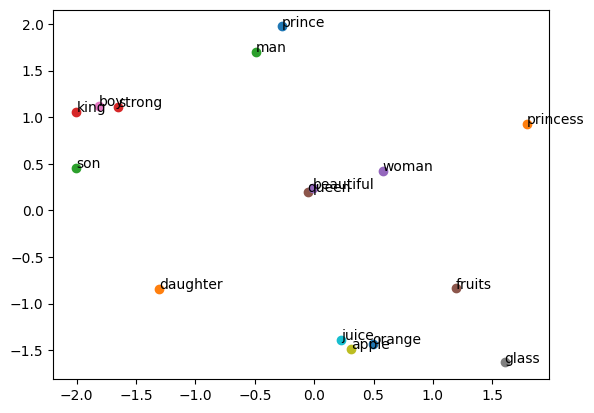

In [42]:
import matplotlib.pyplot as plt

for word in tokenizer.word_index.keys():
    coord = word_embeddings.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))

plt.savefig("img.jpg")